# Dance Diffusion v0.2

### Credits & Changelog

#### Credits

Original notebook by Zach Evans (https://github.com/zqevans, https://twitter.com/zqevans). 

Overall structure and setup code taken from Disco Diffusion (https://www.discodiffusion.com)

Interpolation and audio display code from CRASH inference notebook (https://github.com/simonrouard/CRASH)



Licensed under the MIT License

Copyright (c) 2022 Zach Evans

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.


# Set Up

In [1]:
#@title Check GPU Status
import subprocess
simple_nvidia_smi_display = True#@param {type:"boolean"}
if simple_nvidia_smi_display:
    #!nvidia-smi
    nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
else:
    #!nvidia-smi -i 0 -e 0
    nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
    nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_ecc_note)

GPU 0: A100-SXM4-40GB (UUID: GPU-6a2d9052-3821-98dc-47eb-7c4dd3893754)



In [ ]:
#@title Install dependencies
!git clone https://github.com/harmonai-org/sample-generator
!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
!pip install /content/sample-generator
!pip install /content/v-diffusion-pytorch


In [3]:
#@title Prepare folders
import subprocess, os, sys, ipykernel

def gitclone(url, targetdir=None):
    if targetdir:
        res = subprocess.run(['git', 'clone', url, targetdir], stdout=subprocess.PIPE).stdout.decode('utf-8')
    else:
        res = subprocess.run(['git', 'clone', url], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipi(modulestr):
    res = subprocess.run(['pip', 'install', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def pipie(modulestr):
    res = subprocess.run(['git', 'install', '-e', modulestr], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

def wget(url, outputdir):
    res = subprocess.run(['wget', url, '-P', f'{outputdir}'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(res)

try:
    from google.colab import drive
    print("Google Colab detected. Using Google Drive.")
    is_colab = True
    #@markdown Check to connect your Google Drive
    google_drive = True #@param {type:"boolean"}
    #@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
    save_models_to_google_drive = True #@param {type:"boolean"}
except:
    is_colab = False
    google_drive = False
    save_models_to_google_drive = False
    print("Google Colab not detected.")

if is_colab:
    if google_drive is True:
        drive.mount('/content/drive')
        ai_root = '/content/drive/MyDrive/AI'
        root_path = f'{ai_root}/Dance_Diffusion'
    else:
        root_path = '/content'
else:
    root_path = os.getcwd()

import os
def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

initDirPath = f'{root_path}/init_audio'
createPath(initDirPath)
outDirPath = f'{root_path}/audio_out'
createPath(outDirPath)

if is_colab:
    if google_drive and not save_models_to_google_drive or not google_drive:
        model_path = '/content/models'
        createPath(model_path)
    if google_drive and save_models_to_google_drive:
        model_path = f'{ai_root}/models'
        createPath(model_path)
else:
    model_path = f'{root_path}/models'
    createPath(model_path)

# libraries = f'{root_path}/libraries'
# createPath(libraries)

Google Colab detected. Using Google Drive.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title Imports and definitions
from prefigure.prefigure import get_all_args
from contextlib import contextmanager
from copy import deepcopy
import math
from pathlib import Path

import sys

from diffusion import sampling
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from tqdm import trange
from einops import rearrange

import torchaudio
from audio_diffusion.models import DiffusionAttnUnet1D
import numpy as np

#@title Model code
class DiffusionUncond(nn.Module):
    def __init__(self, global_args):
        super().__init__()

        self.diffusion = DiffusionAttnUnet1D(global_args, n_attn_layers = 6, c_mults = [128, 128, 256, 256] + [512] * 12)
        #self.diffusion_ema = deepcopy(self.diffusion)
        self.rng = torch.quasirandom.SobolEngine(1, scramble=True)

        #@title Sampling code
# Define the noise schedule and sampling loop

import matplotlib.pyplot as plt
import IPython.display as ipd

def plot_and_hear(audio):
    display(ipd.Audio(audio.cpu().clamp(-1, 1), rate=48000))
    plt.plot(audio.cpu().t().numpy())
    
def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def get_crash_schedule(t):
    sigma = torch.sin(t * math.pi / 2) ** 2
    alpha = (1 - sigma ** 2) ** 0.5
    return alpha_sigma_to_t(alpha, sigma)

def t_to_alpha_sigma(t):
    """Returns the scaling factors for the clean image and for the noise, given
    a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def alpha_sigma_to_t(alpha, sigma):
    """Returns a timestep, given the scaling factors for the clean image and for
    the noise."""
    return torch.atan2(sigma, alpha) / math.pi * 2

@torch.no_grad()
def sample(model, x, steps, eta):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    t = get_crash_schedule(t)
    alphas, sigmas = get_alphas_sigmas(t)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * t[i]).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred

#@title Args
sample_size = 65536 
sample_rate = 48000   
latent_dim = 0             

class Object(object):
    pass

args = Object()
args.sample_size = sample_size
args.sample_rate = sample_rate
args.latent_dim = latent_dim


@torch.no_grad()
def sample(model, x, steps, eta, extra_args, callback=None):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    alphas, sigmas = t_to_alpha_sigma(steps)

    # The sampling loop
    for i in trange(len(steps), disable=None):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * steps[i], **extra_args).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # Call the callback
        if callback is not None:
            callback({'x': x, 'i': i, 't': steps[i], 'v': v, 'pred': pred})

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < len(steps) - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


In [5]:
from urllib.parse import urlparse
import hashlib

#@title Create the model
model_name = "ravearchive-340k" #@param ["ravearchive-340k", "custom"]
custom_ckpt_path = ''#@param {type: 'string'}

models_map = {
    "ravearchive-340k": {'downloaded': False, 'sha': "ca6779538e22ea444cbb67b5a19b832f9174041680dc92f336580260456fdf93", 'uri_list': ["https://model-server.zqevans2.workers.dev/ravearchive-uncond-340k.pth"] },
}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

def get_model_filename(diffusion_model_name):
    model_uri = models_map[diffusion_model_name]['uri_list'][0]
    model_filename = os.path.basename(urlparse(model_uri).path)
    return model_filename

def download_model(diffusion_model_name, uri_index=0):
    if diffusion_model_name != 'custom':
        model_filename = get_model_filename(diffusion_model_name)
        model_local_path = os.path.join(model_path, model_filename)
        if os.path.exists(model_local_path) and check_model_SHA:
            print(f'Checking {diffusion_model_name} File')
            with open(model_local_path, "rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest()
                print(f'SHA: {hash}')
            if hash == models_map[diffusion_model_name]['sha']:
                print(f'{diffusion_model_name} SHA matches')
                models_map[diffusion_model_name]['downloaded'] = True
            else:
                print(f"{diffusion_model_name} SHA doesn't match. Will redownload it.")
        elif os.path.exists(model_local_path) and not check_model_SHA or models_map[diffusion_model_name]['downloaded']:
            print(f'{diffusion_model_name} already downloaded. If the file is corrupt, enable check_model_SHA.')
            models_map[diffusion_model_name]['downloaded'] = True

        if not models_map[diffusion_model_name]['downloaded']:
            for model_uri in models_map[diffusion_model_name]['uri_list']:
                wget(model_uri, model_path)
                if os.path.exists(model_local_path):
                    models_map[diffusion_model_name]['downloaded'] = True
                    return
                else:
                    print(f'{diffusion_model_name} model download from {model_uri} failed. Will try any fallback uri.')
            print(f'{diffusion_model_name} download failed.')

if model_name == "custom":
  ckpt_path = custom_ckpt_path
else:
  download_model(model_name)
  ckpt_path = f'{model_path}/{get_model_filename(model_name)}'

model = DiffusionUncond(args)
model.load_state_dict(torch.load(ckpt_path)["model_ema"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.requires_grad_(False).to(device)

# # Remove non-EMA
# del model.diffusion

ravearchive-340k already downloaded. If the file is corrupt, enable check_model_SHA.


# Generate new sounds

In [ ]:
#@markdown Diffusion options
batch_size =  8#@param {type:"number"}
steps =  500#@param {type:"number"}

model_fn = model.diffusion

# def crash_schedule_inv(t):
#     _, sigma = t_to_alpha_sigma(t)
#     return (sigma ** 0.5).asin() / math.pi * 2

# def crash_inv_model_fn(x, t):
#         t = crash_schedule_inv(t)
#         return model_fn(x, t)

def load_to_device(path, sr):
    audio, file_sr = torchaudio.load(path)
    if sr != file_sr:
      audio = torchaudio.transforms.Resample(file_sr, sr)(audio)
    audio = audio.to(device)
    return audio

# Generate random noise to sample from
noise = torch.randn([batch_size, 2, args.sample_size]).to(device)
#generated = sample(model_fn, noise, diffusion_steps, 0)

t = torch.linspace(1, 0, steps + 1, device=device)[:-1]
step_list = get_crash_schedule(t)

# # Generate the samples from the noise
generated = sampling.iplms_sample(model_fn, noise, step_list, {})

# Hard-clip the generated audio
generated = generated.clamp(-1, 1)

# Put the demos together
generated_all = rearrange(generated, 'b d n -> d (b n)')

print("All samples")
plot_and_hear(generated_all)
for ix, gen_sample in enumerate(generated):
  print(f'sample #{ix + 1}')
  display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))

# Regenerate your own sounds

Initial audio sample


  0%|          | 0/158 [00:00<?, ?it/s]

Regenerated audio sample


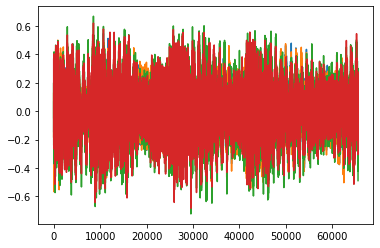

In [7]:
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from audio_diffusion.utils import Stereo, PadCrop
from glob import glob

file_path = "/content/drive/MyDrive/Audio/MrHappy/Mr_Happy.wav" #@param{type:"string"}
filenames = glob(file_path, recursive=True)

steps = 250#@param {type:"number"}
max_timestep = 0.5#@param {type:"number"}

augs = torch.nn.Sequential(
  PadCrop(args.sample_size, randomize=True),
  Stereo()
)

audio_sample = load_to_device(file_path, args.sample_rate)

audio_sample = augs(audio_sample).unsqueeze(0)

print("Initial audio sample")
plot_and_hear(audio_sample[0])

t = torch.linspace(0, 1, steps + 1, device=device)
step_list = get_crash_schedule(t)
step_list = step_list[step_list < max_timestep]

alpha, sigma = t_to_alpha_sigma(step_list[-1])
noised = torch.randn([1, 2, args.sample_size], device='cuda')
noised = audio_sample * alpha + noised * sigma

generated = sampling.iplms_sample(model_fn, noised, step_list.flip(0)[:-1], {})

print("Regenerated audio sample")
plot_and_hear(rearrange(generated, 'b d n -> d (b n)'))
